In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from warnings import filterwarnings

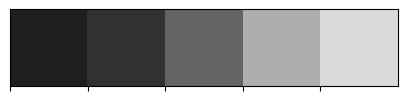

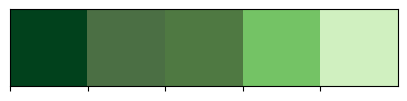

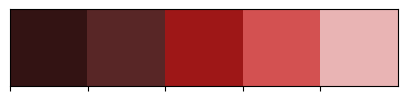

In [15]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [29]:
size = 150
batch = 32
dataset_training_path="/kaggle/input/brain-tumor-classification-mri/Training"
dataset_testing_path="/kaggle/input/brain-tumor-classification-mri/Testing"

# image_size: resizes the images
# batch_size: how many images at a time
# subset: allows me to return a tuple (train_data, val_data)
train_data = image_dataset_from_directory(directory=dataset_training_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

testing_data = image_dataset_from_directory(directory=dataset_testing_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

X_train = []
y_train = []

for images, labels in train_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for images, labels in testing_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy()) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print()
print(f"X_train.shape: {X_train.shape}")
print(f"y_train: {y_train.shape}")

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.

X_train.shape: (3264, 150, 150, 3)
y_train: (3264,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, 
                                                    test_size=0.125,
                                                    random_state=42)

In [31]:
y_test

array([0, 0, 0, 3, 1, 3, 1, 1, 3, 0, 0, 0, 3, 3, 2, 1, 1, 0, 3, 1, 3, 3,
       0, 1, 2, 3, 1, 2, 0, 2, 3, 1, 1, 3, 1, 3, 0, 2, 1, 1, 1, 2, 1, 2,
       3, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 3, 0,
       1, 1, 3, 3, 0, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1,
       1, 0, 3, 3, 3, 0, 1, 2, 2, 0, 0, 1, 3, 2, 3, 1, 1, 0, 0, 1, 0, 0,
       3, 1, 3, 2, 1, 3, 1, 3, 1, 0, 1, 2, 0, 1, 3, 1, 1, 2, 0, 3, 3, 1,
       3, 1, 3, 3, 1, 0, 3, 1, 3, 2, 1, 3, 3, 3, 2, 3, 1, 2, 1, 3, 0, 0,
       3, 2, 3, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 0,
       3, 1, 3, 1, 1, 2, 0, 2, 1, 3, 1, 1, 3, 3, 1, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 0, 1, 3, 3, 1, 1, 1, 0, 1, 3, 0, 3, 1, 1, 3, 3, 3, 0, 3, 1,
       0, 1, 1, 2, 0, 3, 1, 2, 1, 0, 1, 2, 2, 3, 0, 3, 3, 3, 1, 1, 0, 1,
       1, 0, 0, 1, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 3,
       0, 1, 0, 0, 3, 3, 3, 3, 1, 2, 0, 1, 2, 1, 3, 1, 3, 1, 0, 1, 3, 0,
       2, 1, 1, 0, 3, 0, 1, 1, 1, 3, 2, 1, 3, 2, 2,

In [34]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [35]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [58]:
model = Sequential(
  [
      EfficientNetB0(weights='imagenet',
                        include_top=False,
                        input_shape=(image_size,image_size,3)),
      GlobalAveragePooling2D(),
      Dropout(rate=0.5),
      Dense(4, activation='linear')
  ]
)

model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer = Adam(learning_rate=0.001),
              metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [60]:
tensorboard = TensorBoard(log_dir = 'logs')

checkpoint = ModelCheckpoint("effnet.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

In [61]:
history = model.fit(X_train,y_train,
                    validation_split=0.1, 
                    epochs=20, verbose=1, 
                    batch_size=32,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20


2023-11-26 19:56:06.660415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


81/81 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8241
Epoch 1: val_accuracy improved from -inf to 0.79720, saving model to effnet.h5
81/81 [==============================] - 50s 160ms/step - loss: 0.4705 - accuracy: 0.8241 - val_loss: 0.7700 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9381
Epoch 2: val_accuracy improved from 0.79720 to 0.86014, saving model to effnet.h5
81/81 [==============================] - 11s 140ms/step - loss: 0.1960 - accuracy: 0.9381 - val_loss: 0.4509 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9650
Epoch 3: val_accuracy improved from 0.86014 to 0.94406, saving model to effnet.h5
81/81 [==============================] - 11s 139ms/step - loss: 0.1091 - accuracy: 0.9650 - val_loss: 0.2029 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 4/20
81/81 [==============================] -

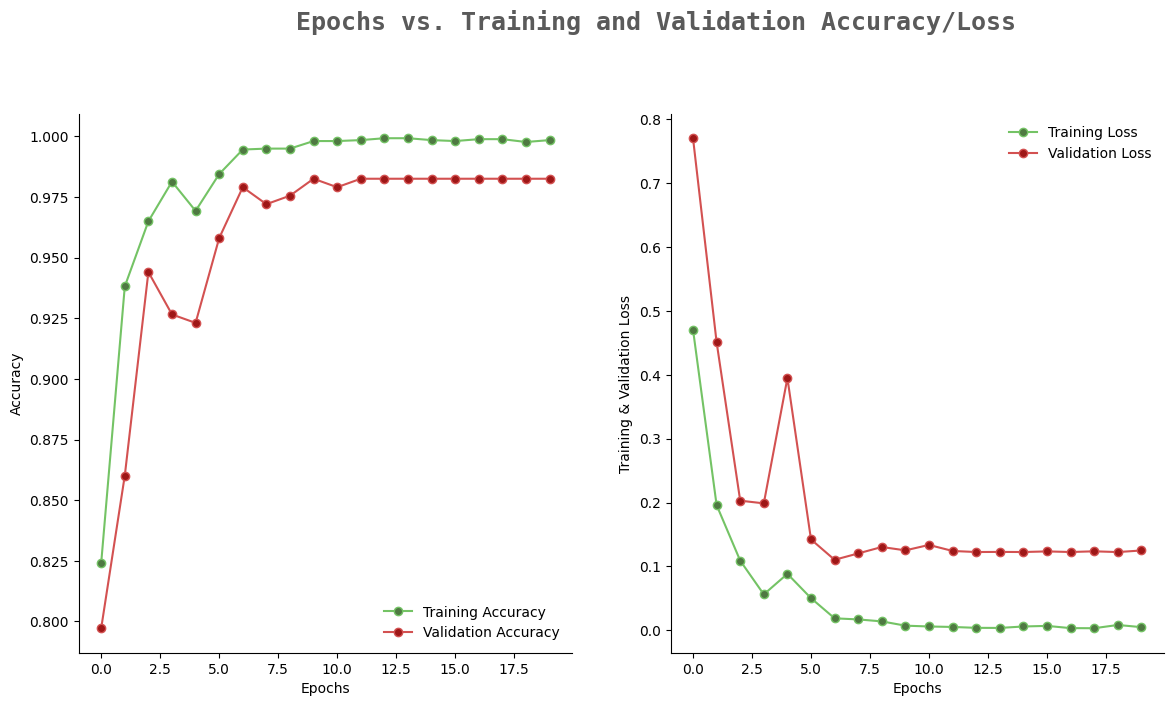

In [63]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',
         size=18,fontweight='bold',
        fontname='monospace',
         color=colors_dark[1],
         y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           markerfacecolor=colors_green[2],
           color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           markerfacecolor=colors_red[2],
           color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [64]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 [==============================] - 2s 35ms/step


In [65]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       109
           1       0.95      0.93      0.94       134
           2       0.95      0.96      0.95        55
           3       0.96      0.99      0.98       110

    accuracy                           0.96       408
   macro avg       0.96      0.96      0.96       408
weighted avg       0.96      0.96      0.96       408



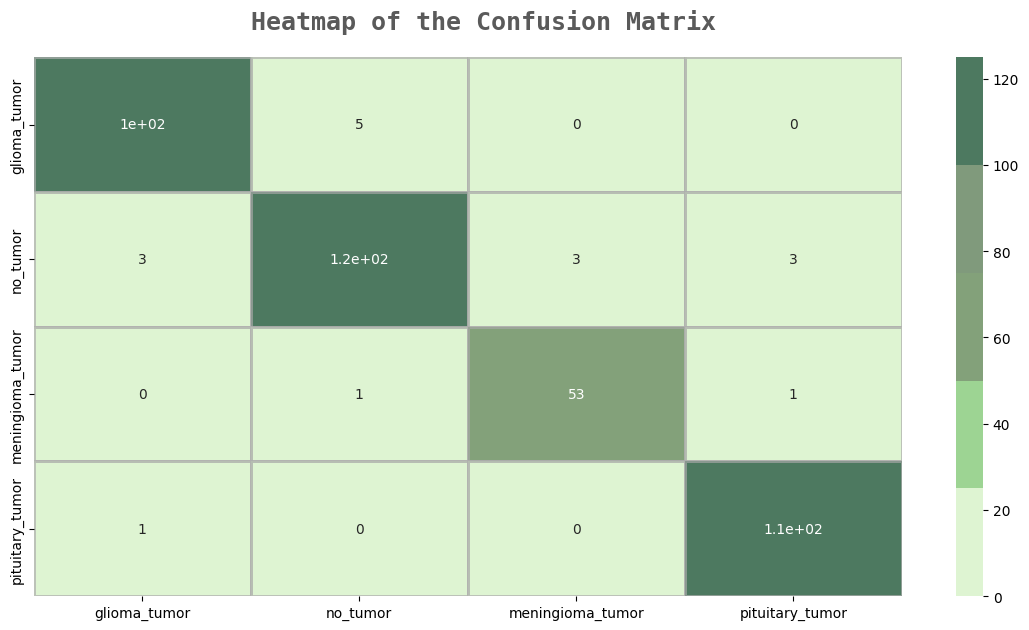

In [66]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,linewidths=2,
            linecolor=colors_dark[3])

fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()
